In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

/home/enf/software/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [3]:
from mor_h8_feature_types import *
from get_variable_names import *
from mor_ligand_atom_residue_tica_config import *
from residue import Residue, Atom

tm6_tm3_residues
[R279, R165]
[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 273, 274, 275, 276, 277, 278,

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib as mpl
from seaborn.apionly import set_palette
from IPython.display import set_matplotlib_formats

# configure plotting
set_matplotlib_formats('pdf', 'svg')
set_palette('Set1', n_colors=15, desat=None)

In [55]:
%matplotlib inline



/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/enf/software/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} wa

In [4]:
sampling_method = "kdtree"
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A
/home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A


In [5]:
print feature_residues_pkl

/home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A/feature_residues.pkl


In [7]:
ligand_residue = Residue(resSeq=900, chain_id="L", res_name="LIG")
ligand_atom_names = ["N1", "O1", "C7", "C17", "O2", "N2", "C26"]
ligand_atoms = []
for atom_name in ligand_atom_names:
    ligand_atoms.append(Atom(resSeq=900, chain_id="L", atom_name=atom_name, res_name="LIG"))

In [8]:
included = "65 65 65 65 65 66 66 66 66 66 66 66 67 67 67 67 67 68 68 68 68 68 69 69 69 69 69 69 69 69 70 70 70 70 70 70 70 71 71 71 71 71 71 71 71 72 72 72 72 72 72 72 72 73 73 73 73 73 74 74 74 74 74 74 74 74 75 75 75 75 75 75 75 75 75 75 75 75 76 76 76 76 76 76 77 77 77 77 77 77 77 77 78 78 78 78 78 78 78 79 79 79 79 79 79 80 80 80 80 80 80 80 81 81 81 81 81 81 81 82 82 82 82 83 83 83 83 83 83 83 83 84 84 84 86 86 86 86 86 87 87 87 87 87 87 87 87 90 90 109 109 109 109 109 110 110 110 110 110 110 111 111 111 111 112 112 112 112 112 112 112 112 113 113 113 113 113 114 114 114 114 114 114 114 114 115 115 115 115 115 116 116 116 116 116 116 116 116 117 117 117 117 117 118 118 118 118 118 118 118 119 119 119 119 119 119 120 120 120 120 120 120 120 121 121 121 121 121 121 121 121 122 122 122 122 122 122 122 123 123 123 123 123 123 123 123 123 123 123 124 124 124 124 124 124 124 124 124 125 125 125 125 125 125 126 126 126 126 126 126 126 127 127 127 127 127 127 127 127 128 128 128 128 128 128 128 128 128 128 128 128 129 129 129 129 129 129 129 129 130 130 130 130 130 130 130 130 131 131 131 131 132 132 132 132 132 132 132 133 133 133 133 133 133 133 133 133 133 133 133 133 133 134 134 134 134 134 134 134 135 135 135 135 135 135 135 135 135 135 135 136 136 136 136 137 137 137 137 137 137 137 137 138 138 138 138 138 138 138 138 139 139 139 139 139 139 139 139 140 140 140 140 140 140 141 141 141 141 141 141 141 141 141 142 142 142 142 142 142 142 142 143 143 143 143 143 143 143 144 144 144 144 144 144 144 144 145 145 145 145 145 145 146 146 146 146 146 146 146 146 147 147 147 147 147 147 147 147 148 148 148 148 148 148 148 148 148 148 148 148 149 149 149 149 149 149 149 149 149 149 149 149 150 150 150 150 150 150 150 150 151 151 151 151 151 151 151 151 152 152 152 152 152 152 152 152 152 152 152 153 153 153 153 153 153 153 154 154 154 154 154 154 155 155 155 155 155 155 155 155 156 156 156 156 156 156 156 156 156 156 156 157 157 157 157 158 158 158 159 159 187 188 188 189 189 189 189 189 189 189 190 190 190 190 190 190 191 191 191 191 191 191 191 191 192 192 192 192 192 192 192 192 192 192 192 192 192 192 193 193 193 193 193 193 193 193 194 194 194 194 194 194 194 194 195 195 195 195 195 195 196 196 196 196 196 196 197 197 197 197 197 198 198 198 198 198 198 198 198 199 199 199 199 200 200 200 200 200 200 200 200 201 201 201 201 201 201 201 202 202 202 202 202 202 202 203 203 203 203 203 203 203 203 204 204 204 204 204 204 204 204 204 204 204 205 205 205 205 205 205 205 205 206 206 206 206 206 207 207 207 207 207 207 207 208 208 208 208 208 208 208 209 209 209 209 209 209 209 209 209 210 210 210 210 210 210 210 210 210 210 210 210 211 211 211 211 211 211 211 211 211 211 211 212 212 212 212 212 212 212 212 212 213 213 213 213 214 214 214 214 214 214 215 215 215 215 215 215 215 215 216 216 216 216 216 216 216 216 217 217 217 217 217 217 218 218 218 218 218 218 218 219 219 219 219 219 219 219 219 220 220 220 220 220 220 220 221 221 221 221 221 221 221 221 221 221 221 222 222 222 222 222 222 223 223 223 223 223 223 223 223 223 223 224 224 224 224 224 224 224 225 225 225 225 225 225 225 226 226 226 226 226 226 226 226 226 226 226 226 226 226 227 227 227 227 227 227 227 227 227 227 227 227 228 228 228 228 228 228 228 228 228 228 228 228 228 228 229 229 229 229 229 229 229 229 229 230 230 230 230 230 230 230 230 231 231 231 231 231 231 231 231 232 232 232 232 232 232 232 232 233 233 233 233 233 233 233 233 233 234 234 234 234 234 234 234 234 235 235 235 235 235 235 236 236 236 236 236 236 236 237 237 237 237 237 237 237 237 237 237 237 238 238 238 238 238 238 238 238 239 239 239 239 239 239 239 239 239 239 239 240 240 240 240 240 241 241 241 241 241 241 241 241 241 241 241 242 242 242 242 242 242 242 242 243 243 243 243 243 243 243 243 244 244 244 244 244 244 244 245 245 245 245 245 245 245 246 246 246 246 246 246 246 246 247 247 247 247 247 248 286 287 288 288 288 288 289 289 289 289 289 289 289 289 289 289 289 290 290 290 290 290 290 290 290 291 291 291 291 291 291 291 292 292 292 292 292 292 293 293 293 293 293 293 293 293 293 293 293 293 293 293 294 294 294 294 294 294 294 295 295 295 295 295 295 295 296 296 296 296 296 296 296 296 297 297 297 297 297 297 297 297 297 297 298 298 298 298 298 298 298 298 299 299 299 299 299 299 299 299 299 299 299 299 300 300 300 300 300 300 300 301 301 301 301 301 301 301 301 302 302 302 302 302 302 302 302 303 303 303 303 303 303 303 303 303 304 304 304 304 304 305 305 305 305 305 305 305 305 306 306 306 306 306 306 306 306 307 307 307 307 307 307 307 308 308 308 308 308 308 308 308 309 309 309 309 309 309 309 310 310 310 310 310 310 310 310 310 311 311 311 311 311 311 311 312 312 312 312 312 312 312 313 313 313 313 313 313 313 313 313 313 313 314 314 314 314 314 314 314 314 314 315 315 315 315 315 315 315 316 316 316 316 316 316 316 317 317 317 317 317 317 318 318 318 318 318 318 318 318 318 318 318 318 318 318 319 319 319 319 319 319 319 319 319 319 320 320 320 320 320 320 320 320 320 320 320 321 321 321 321 321 321 322 322 322 322 322 322 322 322 323 323 323 323 323 324 324 324 324 324 324 324 324 325 325 325 325 326 326 326 326 326 326 326 326 326 326 326 326 327 327 327 327 327 327 327 328 328 328 328 328 328 328 328 329 329 329 329 329 329 330 330 330 330 330 330 331 331 331 331 331 331 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601 601"
included_list = set(included.split())
included_list = sorted([int(i) for i in included_list])
print(included_list)
len(included_list)

[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 90, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 601]


183

In [9]:
excluded_set = set(list(range(270, 292)) + list(range(239, 263)) + list(range(153, 170)) + list(range(170, 197)) + list(range(102, 116)) + list(range(80, 102)) + list(range(326, 350)))
included_residues = [res for res in contact_residues if res.resSeq in included_list]
user_specified_contact_residue_pairs = [(ligand_residue, contact_residue) for contact_residue in contact_residues if contact_residue.resSeq in included_list]
user_specified_atom_residue_pairs = [x for x in itertools.product(ligand_atoms, included_residues)]
print(user_specified_contact_residue_pairs)
print(user_specified_atom_residue_pairs)

[(LIG, ILE198), (LIG, ILE69), (LIG, ARG211), (LIG, ASN127), (LIG, ILE193), (LIG, THR132), (LIG, PRO134), (LIG, THR220), (LIG, HIS297), (LIG, GLY82), (LIG, GLU229), (LIG, ILE215), (LIG, THR67), (LIG, LEU116), (LIG, LEU112), (LIG, ALA113), (LIG, LEU110), (LIG, ALA323), (LIG, CYS159), (LIG, LEU194), (LIG, ILE322), (LIG, LEU83), (LIG, VAL245), (LIG, LEU219), (LIG, GLN314), (LIG, ALA287), (LIG, SER125), (LIG, ALA197), (LIG, ASN328), (LIG, ASN150), (LIG, VAL187), (LIG, TYR210), (LIG, VAL80), (LIG, VAL81), (LIG, ALA115), (LIG, TYR299), (LIG, THR120), (LIG, THR70), (LIG, ALA117), (LIG, MET130), (LIG, CYS79), (LIG, GLN124), (LIG, SER329), (LIG, ALA111), (LIG, ILE298), (LIG, ASN230), (LIG, PRO244), (LIG, VAL236), (LIG, ILE296), (LIG, PRO295), (LIG, GLY136), (LIG, GLY199), (LIG, PHE123), (LIG, SER154), (LIG, LEU74), (LIG, MET65), (LIG, PRO224), (LIG, PRO122), (LIG, VAL78), (LIG, THR153), (LIG, THR327), (LIG, THR157), (LIG, LEU139), (LIG, ASP216), (LIG, SER317), (LIG, PHE204), (LIG, THR225), (LIG,

In [10]:
print(len(user_specified_atom_residue_pairs))
print(len(user_specified_atom_residue_pairs))

1274
1274


In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = True, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = user_specified_atom_residue_pairs, worker_pool=None)

In [11]:
import pickle
with open(feature_residues_pkl, "rb") as f:
    feature_residues = pickle.load(f)
print(feature_residues[0])
print(feature_residues[0][0].__dict__)
print(feature_residues[0][1].__dict__)
print(feature_residues[727])

(Lig900-N1, Ile198)
{'mdtraj_rep': 'Lig900-N1', 'chain_id': 'L', 'res_name': 'LIG', 'resSeq': 900, 'atom_id': None, 'atom_name': 'N1'}
{'ballosteros_weinstein': None, 'chain_name': None, 'CA': False, 'chain_id': 'R', 'res_name': 'Ile198', 'resSeq': 198, 'mean': None}
(Lig900-C17, Val316)


In [73]:
[i for i in range(0, len(feature_residues)) if ("N1" in str(feature_residues[i]) and "147" in str(feature_residues[i])) or ("O1" in str(feature_residues[i]) and "297" in str(feature_residues[i])) or ("N1" in str(feature_residues[i]) and "326" in str(feature_residues[i]))]

[143, 175, 190]

In [61]:
feature_residues[175]

(Lig900-N1, Asp147)

In [ ]:
feature_files = get_trajectory_files(features_dir, ".dataset")
specific_features = [load_file(filename)[:,[143, 175, 190]] for filename in feature_files]

loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_0-0.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_0-1.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_0-2.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_0-3.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_1-0.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_1-1.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_1-2.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4

In [ ]:
good_trajs = []
for i, traj in enumerate(specific_features):
    if len(np.where((traj[:,0] < 0.4) & (traj[:,1] < 0.7))[0]) > 0: good_trajs.append(i)
[get_trajectory_files(traj_dir, traj_ext)[i] for i in good_trajs]

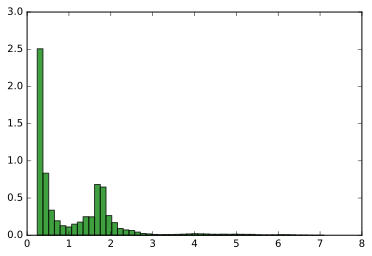

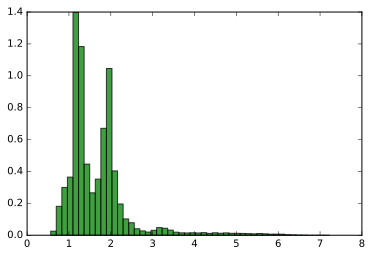

In [60]:
plt.clf()
plt.hist(np.concatenate(specific_features)[:,0], 50, normed=1, facecolor='green', alpha=0.75)
plt.show()
plt.hist(np.concatenate(specific_features)[:,1], 50, normed=1, facecolor='green', alpha=0.75)
plt.show()


In [11]:
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext)

loading feature files
(313, 1274)
[ 1.18956435  2.08111882  2.18173814  1.30730188  1.74587703  1.95198607
  1.96003914  1.36619985  0.68327397  1.65081668]
(156,)
[ 0.99777663  1.08767939  1.19500411 ...,  1.02755189  0.86726874
  0.99870569]loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_BFNA_CO_0-0.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_BFNA_CO_2-2.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_BFNA_CO_1-1.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_COB_1-4.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_COB_3-4.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_COB_5-4.dat

In [13]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...
()
None
Done plotting columns


In [ ]:
%load_ext autoreload
%autoreload 2

In [12]:
from interpret_tICs import *
tic_components_dir = tica_dir
interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)


loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_tica_coords.h5"...
Interpreting tIC 1
feature_importances_df.shape
(10, 7)
residue_importances_df.shape
(14, 3)
        feature_name       res_i   res_j  resid_i  resid_j  importance  \
4   Lig900-N1-Asp147   Lig900-N1  Asp147      900      147    0.461965   
5   Lig900-C7-Val300   Lig900-C7  Val300      900      300    0.422095   
1   Lig900-N1-Tyr299   Lig900-N1  Tyr299      900      299   -0.383959   
3   Lig900-N1-Thr218   Lig900-N1  Thr218      900      218   -0.312445   
6  Lig900-C17-Ile296  Lig900-C17  Ile296      900      296    0.218596   
8  Lig900-C26-Cys217  Lig900-C26  Cys217      900      217    0.178930   
9  Lig900-C26-Thr218  Lig900-C26  Thr218      900      218    0.177101   
7   Lig900-O2-Thr312   Lig900-O2  Thr312      900      312   -0.158275   
0   Lig900-N1-Arg211   Lig900-

[(Lig900-N1, Tyr149),
 (Lig900-O1, Ser145),
 (Lig900-N1, Asn230),
 (Lig900-C26, Pro134),
 (Lig900-O1, Asn150),
 (Lig900-C26, Met205),
 (Lig900-C17, Ile322),
 (Lig900-C17, Cys159),
 (Lig900-C17, Trp133),
 (Lig900-N1, Phe320),
 (Lig900-N1, Ile306),
 (Lig900-N1, Cys217),
 (Lig900-C26, Ser222),
 (Lig900-N1, Phe221),
 (Lig900-C17, Phe135),
 (Lig900-N2, Thr218),
 (Lig900-C7, Ile301),
 (Lig900-N1, Met203),
 (Lig900-O1, Ser119),
 (Lig900-C26, Asp147),
 (Lig900-N2, Pro295),
 (Lig900-C7, Val300),
 (Lig900-N1, Ile302),
 (Lig900-N1, Gly325),
 (Lig900-C26, Cys140),
 (Lig900-O2, Tyr227),
 (Lig900-C7, Leu231),
 (Lig900-C26, Thr327),
 (Lig900-C26, Trp318),
 (Lig900-C26, Tyr227),
 (Lig900-O1, Ile138),
 (Lig900-O1, Ser222),
 (Lig900-O1, Met72),
 (Lig900-C26, Lys141),
 (Lig900-O1, Ile146),
 (Lig900-N2, Leu129),
 (Lig900-C7, Phe289),
 (Lig900-C26, Thr70),
 (Lig900-O1, Asp147),
 (Lig900-N1, Phe241),
 (Lig900-C26, Asn109),
 (Lig900-C26, Trp293),
 (Lig900-N2, Leu305),
 (Lig900-O1, Trp318),
 (Lig900-O2, Trp29

In [25]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...
()
None
Done plotting columns


In [15]:
tica_object = verboseload(projection_operator_dir)
tica_object.timescales_

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_tica_coords.h5"...


array([ 914.9342963 ,  483.78409223,  196.10798161,  138.8546117 ,
        111.18195913,   89.14772817,   78.70403562,   76.9404398 ,
         76.20161803,   66.07007831])

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
compute_user_defined_features_wrapper(traj_dir, traj_ext, inactive_dir, active_dir, structure,
                                          feature_name_residues_dict, user_defined_features_file)
plot_columns(pnas_features_dir, user_defined_features_file, titles = feature_name_residues_dict.keys(), tICA=False, scale=1.0, refcoords_file=None)

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
coords_bounds_dict = {"tm6_tm3_dist": [6.0, 8.0, 10.0]}
reaction_coordinate_sampler(traj_dir, traj_ext, user_defined_features_file, 
                                feature_name_residues_dict, coords_bounds_dict, reaction_coordinates_trajs_file)

In [6]:
n_clusters = 100
clusterer_dir = "%s/clusterer%d_tICs_1-5.h5" %(tica_dir, n_clusters)
cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters, clusterer_dir, tICs=list(range(0,5)))

Already clustered


In [7]:
projected_features_tICs_1_5_filename = "%s/projected_features_tICs_1-5.h5" %tica_dir
#projected_features = verboseload(projected_features_dir)
#projected_features = [f[:, range(0,5)] for f in projected_features]
#verbosedump(projected_features, projected_features_tICs_1_5_filename)

In [8]:
samples_indices_file = "%s/clusterer_100_tICs_1-5_10samples.h5"
if not os.path.exists(save_dir): os.makedirs(save_dir)
#sample_from_clusterer(clusterer_dir, projected_features_tICs_1_5_filename, get_trajectory_files(traj_dir, ".h5"), 
#                      n_samples, save_dir, samples_indices_file, structure=None,
#                      residue_cutoff=10000, parallel=True,
#                      worker_pool=None)

In [17]:
from analysis import *
plot_all_tics_and_clusters(tica_dir, projected_features_dir, clusterer_dir, lag_time, label = "cluster_id", active_cluster_ids = range(0,100), tic_range=range(0,5), intermediate_cluster_ids = [], inactive_cluster_ids = [])

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer100_tICs_1-5.h5"...
[[ -9.34628501e-01  -3.58187347e-01   2.41246848e-01   2.64516524e-01
    4.99334862e-01]
 [  1.22819343e+00  -1.12114521e+00  -7.89740105e-04  -5.24144998e-01
    3.50767052e-02]
 [  7.12440064e-01  -3.25371070e-01   1.20133505e+00   2.94590569e+00
   -2.88853080e+00]
 [  5.78749631e-01   2.03123588e+00  -1.47904825e+00  -3.80297448e-01
   -1.38480456e-01]
 [ -1.07144702e+00  -1.27534396e-01   3.00193492e-01  -5.05780100e-01
   -3.16427204e-01]
 [  1.74903648e+00   2.12561288e+00   2.54784865e+00  -1.02471045e-01
    1.78180192e+00]
 [  1.35928816e-01   6.81737508e-01  -1.93363983e+0

In [88]:
import custom_msm
reload(custom_msm)
from custom_msm import *
plot_timescales(clusterer_dir, n_clusters, tica_dir, main="Ligand Binding MSM", lag_times=range(1,26,5))

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer100_tICs_1-5.h5"...
MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=10, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)
MSM contains 2 strongly connected components above weight=1.00. Component 0 selected, with population 99.447185%
MSM contains 3 strongly connected components above weight=0.17. Component 1 selected, with population 98.432639%
MSM contains 3 strongly connected components above weight=0.09. Component 1 selected, with population 98.421912%
MSM contains 3 strongly connected components above weight=0.06. Component 1 selected, with population 98.410934%
MSM contains 3 strongly connected components above weight=0.05. Component 1 selected, with population 98.3996

In [20]:
lag_time = 10
msm_string = "msm_%dclusters_lag_time%d" % (n_clusters, lag_time)
msm_model_dir = "%s/%s.h5" % (tica_dir, msm_string)
build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)


loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer100_tICs_1-5.h5"...
fitting msm to trajectories with 100 clusters and lag_time 10
MSM contains 3 strongly connected components above weight=0.10. Component 1 selected, with population 98.424077%
MarkovStateModel(ergodic_cutoff='on', lag_time=10, n_timescales=None,
         prior_counts=0.0, reversible_type='mle', sliding_window=True,
         verbose=True)
Saving "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/msm_100clusters_lag_time10.h5"... (<class 'msmbuilder.msm.msm.MarkovStateModel'>)
fitted msm to trajectories with 98 states


MarkovStateModel(ergodic_cutoff='on', lag_time=10, n_timescales=None,
         prior_counts=0.0, reversible_type='mle', sliding_window=True,
         verbose=True)

In [23]:
from msm_resampled import *
total_samples = 10000
msm_obj = verboseload(msm_model_dir)
clusters_map = make_clusters_map(verboseload(clusterer_dir))
num_trajs = len(get_trajectory_files(traj_dir, traj_ext))
msm_resampled_file = "%s/%s_resampled.h5" %(tica_dir, msm_string)
eq_pops = msm_obj.populations_
traj_to_frames = resample_by_msm(total_samples, msm_object=msm_obj, clusters_map=clusters_map, num_trajs=num_trajs, save_file=msm_resampled_file, equilibrium_populations=eq_pops)
tICA_resampled_file = "%s/%s_eq_tICA_resampled.h5" %(tica_dir, msm_string)
resample_features_by_msm_equilibirum_pop(verboseload(projected_features_dir), traj_to_frames, tICA_resampled_file)

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/msm_100clusters_lag_time10.h5"...
loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer100_tICs_1-5.h5"...
566
1395
358
376
1315
222
392
823
168
180
364
129
300
467
321
881
1257
966
656
692
1541
1877
1609
1500
355
382
898
394
686
370
217
453
205
263
391
574
2566
351
352
197
354
555
192
502
793
1715
301
1343
359
2151
309
463
276
325
330
2361
231
241
290
253
703
359
797
693
314
1003
683
202
352
469
650
1474
459
592
1576
1129
247
378
359
262
329
920
2376
675
2080
1657
821
202
700
278
905
789
2036
225
298
314
353
162
140
762
Found number to sample per cluster based on equilibrium proporrtions.
Obtained random (trajectory, frame) pairs based on equilibrium populations
Rearranged equilibrium sampled

In [27]:
from jointplot_d3 import *
jointplots(verboseload(tICA_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,6)], main = "BU72 MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2, min_density=None, max_diff=2.5)

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/msm_100clusters_lag_time10_eq_tICA_resampled.h5"...
()
None
(2, 10002)
Computed 2D KDE
Computed Density. Now plotting.
Done plotting columns


In [28]:
def calculate_cluster_averages_per_feature(clusterer, features):
  n_clusters = clusterer.n_clusters 
  concatenated_clusters = np.concatenate(clusterer.labels_)
  concatenated_features = np.concatenate(features)
  cluster_averages = np.zeros((n_clusters, concatenated_features.shape[1]))
  for i in range(0, n_clusters):
    rows = np.where(concatenated_clusters == i)[0]
    means = np.mean(concatenated_features[rows,:], axis=0)
    cluster_averages[i,:] = means
  return cluster_averages

clusterer = verboseload(clusterer_dir)
tica_coords = verboseload(projected_features_dir)
tica_cluster_averages = calculate_cluster_averages_per_feature(clusterer, tica_coords)

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer100_tICs_1-5.h5"...
loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...


In [31]:
allosteric_clusters = [i for i in range(0,n_clusters) if (tica_cluster_averages[i][0] > 1. and tica_cluster_averages[i][0] < 1.2) and (tica_cluster_averages[i][1] > -1.2 and tica_cluster_averages[i][1] < -1.)]
orthosteric_clusters = [i for i in range(0,n_clusters) if (tica_cluster_averages[i][0] > -1.3 and tica_cluster_averages[i][0] < -1.) and (tica_cluster_averages[i][1] > -.5 and tica_cluster_averages[i][1] < 0.)]

In [32]:
print(allosteric_clusters)
print(orthosteric_clusters)

[49, 55, 63, 74]
[4, 16, 20, 22, 23, 36, 45, 47, 60, 62, 71, 75, 81, 83, 84, 85, 86, 91]


In [72]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *

sources = [msm_obj.mapping_[i] for i in allosteric_clusters]
sinks = [msm_obj.mapping_[i] for i in orthosteric_clusters]
bu72_tpt_paths_file = "%s/%s_bu72_tpt_paths.h5" %(tica_dir, msm_string)
tpt_paths, inv_tpt_paths, _ = generate_tpt_traj_index_series(msm_obj, sources=sources, sinks=sinks, clusters_map=clusters_map, num_paths=10, remove_path = 'subtract', save_file=bu72_tpt_paths_file)

([array([61, 49, 73]), array([61, 14, 92, 23, 52, 42, 43]), array([61, 62, 14, 92, 40, 57, 42, 43]), array([61, 25, 78, 28,  9, 43]), array([61, 25, 49, 73]), array([61, 93, 96,  9, 43]), array([61, 62, 40, 57, 42, 34]), array([47, 93, 48,  9, 43]), array([47, 25, 62, 92, 57, 42, 21]), array([72, 25, 14, 40, 85, 65, 57, 42, 43])], array([  3.64444309e-06,   2.91033930e-06,   2.83419747e-06,
         2.08137982e-06,   2.01276237e-06,   1.82090249e-06,
         1.35482027e-06,   1.28517547e-06,   1.13094613e-06,
         8.11752551e-07]))
path = [61 49 73]
path = [61 14 92 23 52 42 43]
path = [61 62 14 92 40 57 42 43]
path = [61 25 78 28  9 43]
path = [61 25 49 73]
path = [61 93 96  9 43]
path = [61 62 40 57 42 34]
path = [47 93 48  9 43]
path = [47 25 62 92 57 42 21]
path = [72 25 14 40 85 65 57 42 43]
Saving "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/msm_100clusters_l

In [73]:
tpt_paths

[array([61, 49, 73]),
 array([61, 14, 92, 23, 52, 42, 43]),
 array([61, 62, 14, 92, 40, 57, 42, 43]),
 array([61, 25, 78, 28,  9, 43]),
 array([61, 25, 49, 73]),
 array([61, 93, 96,  9, 43]),
 array([61, 62, 40, 57, 42, 34]),
 array([47, 93, 48,  9, 43]),
 array([47, 25, 62, 92, 57, 42, 21]),
 array([72, 25, 14, 40, 85, 65, 57, 42, 43])]

In [75]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
tpt_paths_tica = []
for tpt_path in inv_tpt_paths:
    tpt_paths_tica.append([tica_cluster_averages[i] for i in tpt_path])
jointplots(verboseload(tICA_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,6)], main = "BU72 MSM, TPT", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=2, min_density=None, max_diff=2.5, tpt_paths=tpt_paths_tica)

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/msm_100clusters_lag_time10_eq_tICA_resampled.h5"...
()
None
(2, 10002)
Computed 2D KDE
Computed Density. Now plotting.
[[array([ 1.00497439, -1.07252294, -0.16072256, -0.06148198, -0.06213704,
       -0.31391731, -0.24234157, -0.58887546,  0.24290471,  0.18490662]), array([ 0.96695845, -0.93746308, -0.34059275,  0.92545757, -0.05330412,
        0.07856399,  0.29640996, -0.11935103,  0.20075063, -1.66330715]), array([-1.01799173, -0.17656788, -0.0088799 ,  0.41424957,  1.00075162,
       -0.71408619,  0.05240624,  1.04460647,  0.00430459, -0.76513189])], [array([ 1.00497439, -1.07252294, -0.16072256, -0.06148198, -0.06213704,
       -0.31391731, -0.24234157, -0.58887546,  0.24290471,  0.18490662]), array([ 0.88350492, -1.01166369,  0.25254746,  0.84345468, -0.48078082,
       -0.00456245, -0.00198579, -0.82645097, -0.2

In [58]:
np.array([(p[0], p[1]) for p in tpt_paths_tica[0]])
    

array([[ 1.09466053,  1.42140909],
       [ 1.19087282, -1.10265717],
       [ 0.708041  ,  0.37911803]])

In [44]:
tpt_paths_tica

[[array([[  1.09466053e+00,   1.42140909e+00,   1.99226561e-01,
           -7.71332402e-01,  -5.28619184e-01,   1.53526407e-01,
            4.01570065e-01,   7.04596483e-01,   8.26962483e-01,
           -4.41479705e+00],
         [  1.19087282e+00,  -1.10265717e+00,  -1.39222613e-01,
           -5.23384366e-01,   5.06389885e-01,  -1.84263235e-01,
           -2.67536131e-01,  -1.61635453e-01,   1.91265567e-03,
            2.21485058e-01],
         [  7.08041004e-01,   3.79118028e-01,  -1.61415851e+00,
            2.54942047e-01,  -1.42651331e+00,  -2.75114923e-01,
            7.02509704e-01,   1.78346602e+00,   5.74345187e-01,
            9.17666991e-01]]),
  array([[  1.09466053e+00,   1.42140909e+00,   1.99226561e-01,
           -7.71332402e-01,  -5.28619184e-01,   1.53526407e-01,
            4.01570065e-01,   7.04596483e-01,   8.26962483e-01,
           -4.41479705e+00],
         [  8.83504917e-01,  -1.01166369e+00,   2.52547462e-01,
            8.43454675e-01,  -4.80780815e-01,  -4.

In [87]:
import custom_msm
reload(custom_msm)
from custom_msm import *
graph_file = "%s/%s_graph.graphml" % (tica_dir, msm_string)
cluster_attributes = {}
cluster_attributes["tIC.1"] = [c[0] for c in tica_cluster_averages]

msm_attributes = {}
msm_attributes["msm_equilibrium_populations"] = msm_obj.populations_

msm_graph = construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None, cluster_attributes=cluster_attributes, msm_attributes=msm_attributes)

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer100_tICs_1-5.h5"...
loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/msm_100clusters_lag_time10.h5"...
98


In [83]:
msm_graph.nodes(0)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [36]:
allo_trajs = []
for i, traj in enumerate(get_trajectory_files(traj_dir, traj_ext)):
    if "allo" in traj.lower():
        allo_trajs.append(i)

allo_tica_file = "%s/allo_tica.h5" % tica_dir

tica_coords = verboseload(projected_features_dir)
allo_tica = [tica_coords[i] for i in allo_trajs]

verbosedump(allo_tica, allo_tica_file)

columns = ["tIC%d" %i for i in range(1,n_components+1)]
plot_columns(tica_dir, allo_tica_file, titles=columns, main = "Allosteric", tICA = False, scale = 1.0, refcoords_file = None, concatenate=True)




loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/allo_tica.h5"... (<type 'list'>)
loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/allo_tica.h5"...
()
None
Done plotting columns


In [38]:
np.shape(np.concatenate(tica_coords))

(69076, 10)

In [32]:
allo_tica = verboseload("/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/allo_tica.h5")

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/allo_tica.h5"...


In [35]:
np.shape(np.concatenate(allo_tica))

(18458, 10)

In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = '/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/tica_ligand_protein_contacts_3_sparse_0pt0025/sampled_frames_clusters50_samples1.h5'
msm_trajectory_filename = '/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/tica_ligand_protein_contacts_3_sparse_0pt0025/msm_lagtime5_start48_3'
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=48, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)